(240, 320, 3)
(110, 45, 3)


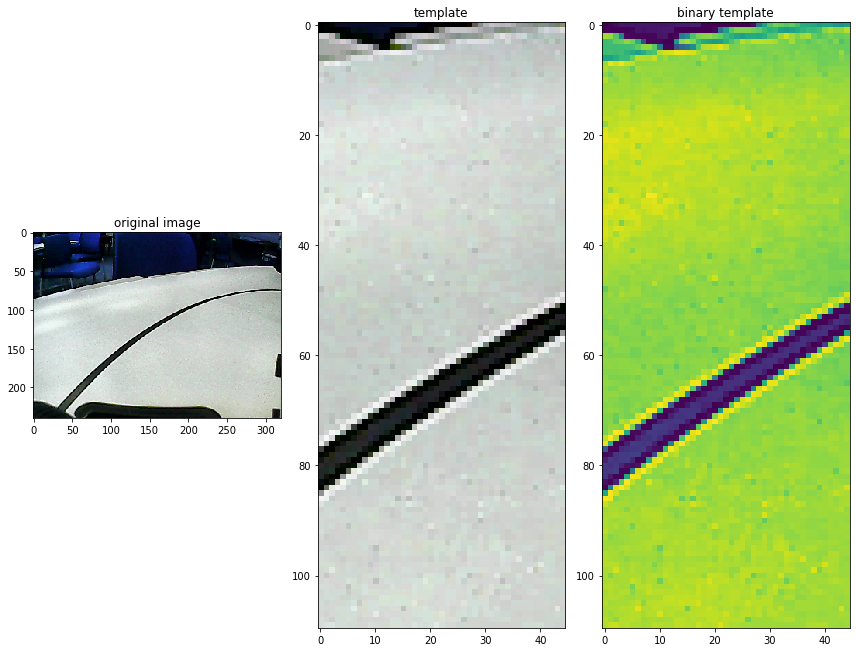

In [1]:
from skimage import io
import image_filtering_functions as sio
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.color import rgb2gray, gray2rgb, rgb2hsv
#loading an image and displaying with human, getting good example from our data
#working first on human detection, to help NN
#master pic is from human_stopped data: 1583246765305_90_0.png
data_dir_human = '../../Data/captureOVAL2-28_02_2020/1582901296132_110_35.png'
data_dir_test = '../../Data/training_data/training_data/127.png'
image_original = io.imread(data_dir_human)
image = exposure.equalize_adapthist(image_original)
test_image_original = io.imread(data_dir_test)
test_image = exposure.equalize_adapthist(test_image_original)
template = image[55:165, 135:180]
binary_template = rgb2gray(template)
binary_image = rgb2gray(image)
binary_test_image = rgb2gray(test_image)
print(image.shape)
print(template.shape)
fig = sio.triple_figure(12, 10, image, template, binary_template, 'original image', 'template', 'binary template',
                        share_axis = False, axis = 'on', tight = True)
plt.show()

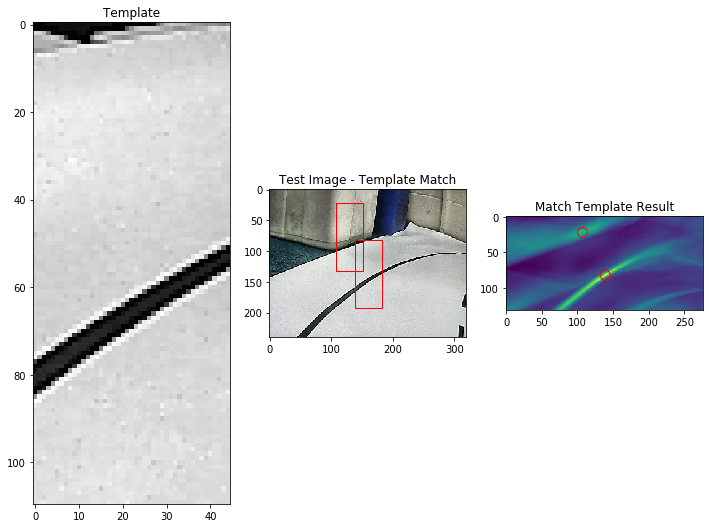

In [2]:
#template matching
import numpy as np
from skimage.feature import match_template
from skimage.feature import peak_local_max

result = match_template(binary_test_image, binary_template, pad_input=False)
peaks = peak_local_max(result,min_distance=10,threshold_rel=0.5)
fig = sio.template_match_img(12, 10, binary_template, test_image, result, peaks, 
              'Template',
              'Test Image - Template Match',
              'Match Template Result',
              share_axis=False, axis='on', tight=False)
plt.show()

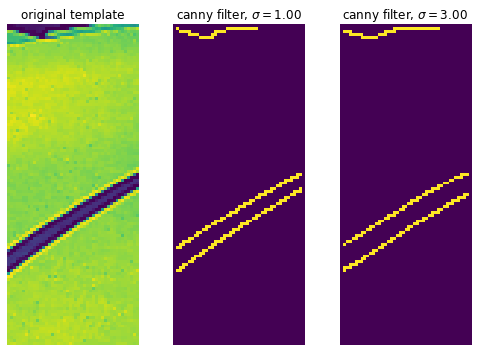

In [3]:
from skimage import feature

edge1 = feature.canny(binary_template, sigma=1, low_threshold=0.3, high_threshold=0.9)
edge2 = feature.canny(binary_template, sigma=3, low_threshold=0.1, high_threshold=0.5)

fig = sio.triple_figure(7, 5, binary_template, edge1, edge2, 
              'original template',
              'canny filter, $\sigma=%.2f$'%(1),
              'canny filter, $\sigma=%.2f$'%(3),
              share_axis=True, tight=True)

plt.show()


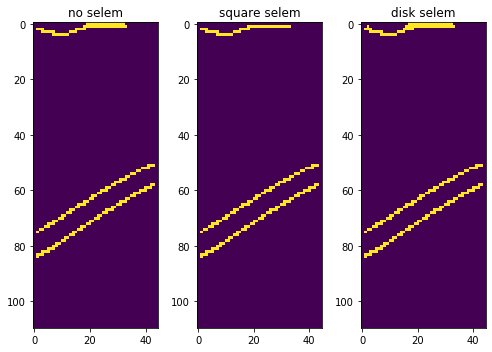

In [4]:
from skimage.morphology import closing, square, disk, flood_fill, flood

closed_template = closing(edge2)
closed_template2 = closing(edge2, square(2)) #best result
closed_template3 = closing(edge2, disk(2))

fig = sio.triple_figure(7,5, closed_template, closed_template2, closed_template3,
                       'no selem', 'square selem', 'disk selem', share_axis=False, axis='on', tight=True)

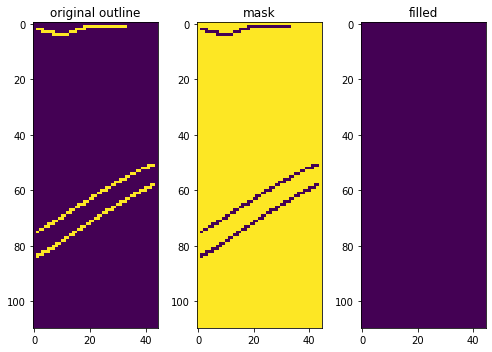

In [5]:
import numpy
import sys
#numpy.set_printoptions(threshold=sys.maxsize)
final_template = closed_template2.copy()
mask = flood(closed_template2, (1, 1), connectivity=1)
final_template[mask] = 1
#print(mask)
fig = sio.triple_figure(7,5, closed_template2, mask, final_template,
                       'original outline', 'mask', 'filled', share_axis=False, axis='on', tight=True)

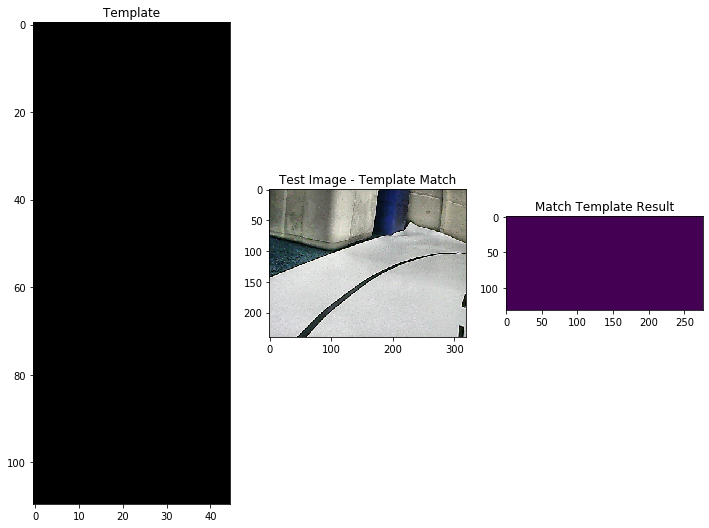

In [6]:
result = match_template(binary_test_image, final_template, pad_input=False)
peaks = peak_local_max(result,min_distance=10,threshold_rel=0.5)
fig = sio.template_match_img(12, 10, final_template, test_image, result, peaks, 
              'Template',
              'Test Image - Template Match',
              'Match Template Result',
              share_axis=False, axis='on', tight=False)
plt.show()

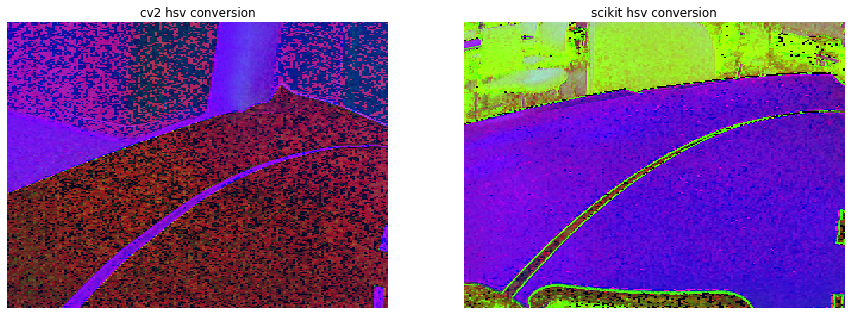

In [7]:
import cv2

test = rgb2hsv(image)
hsv = cv2.cvtColor(~test_image_original, cv2.COLOR_BGR2HSV)
sio.double_figure(15, 13, hsv, test, 'cv2 hsv conversion', 'scikit hsv conversion')
plt.show()

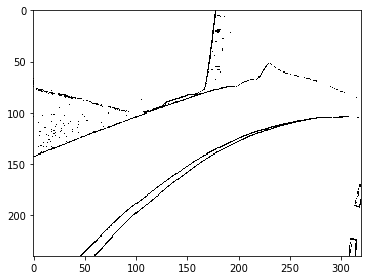

In [8]:
#isolate the lanes
lower_black = np.array([0, 0, 0])
upper_black = np.array([180, 255, 250])
mask = cv2.inRange(hsv, lower_black, upper_black)
io.imshow(mask)

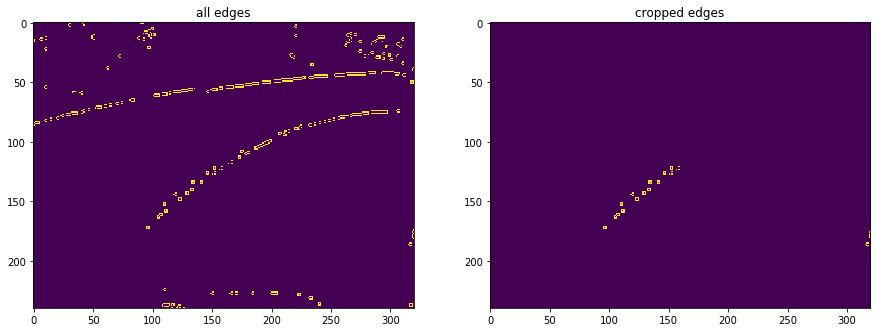

In [9]:
edges = sio.detect_edges(image_original)
roi = sio.region_of_interest(edges)
sio.double_figure(15, 13, edges, roi, 'all edges', 'cropped edges', share_axis=False, axis='on')
plt.show()

E:\Anaconda\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


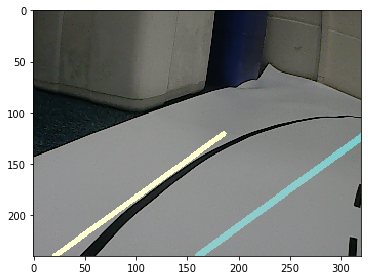

In [10]:
#line_segments = sio.detect_line_segments(roi)
lane_lines = sio.detect_lane(test_image_original)
steering_angle = sio.compute_steering_angle(test_image_original, lane_lines)
lane_lines_image = sio.display_heading_line(test_image_original, steering_angle)
lane_lines_image = sio.display_lines(lane_lines_image, lane_lines)
io.imshow(lane_lines_image)

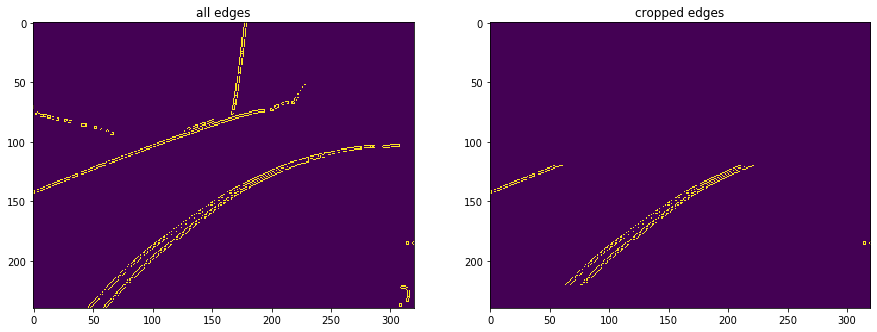

In [11]:
def test_detect_edges(frame):
    #filter for black lane markings
    #first increase contrast in order to filter out noise
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.equalizeHist(frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    #invert pixels as it facilitates detection
    hsv = cv2.cvtColor(~frame, cv2.COLOR_BGR2HSV)
    #show_image("hsv", hsv)
    #image is inverted so filter out white instead of black
    lower_black = np.array([0, 0, 253])
    upper_black = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower_black, upper_black)
    #show_image("black mask", mask)

    # detect edges
    edges = cv2.Canny(mask, 200, 400)

    return edges

edges = test_detect_edges(test_image_original)
roi = sio.region_of_interest(edges)
sio.double_figure(15, 13, edges, roi, 'all edges', 'cropped edges', share_axis=False, axis='on')
plt.show()